In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

In [2]:

import qiskit
from qiskit import *
from qiskit.compiler import assemble
from qiskit.visualization import plot_histogram


import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tqdm import tqdm

In [3]:
shots = 4000
number = 2
equality = shots / np.power(2, number)

# Concept

The third trial builds upon second trial. From second trial, we learned that we can't use a generative model as gradient is not differentiable through `qiskit.Circuit` (at least for now, or perhaps with my skills insufficient to make it differentiable). 

Then, let's subject to supervised learning. 

First, we will generate a dataset using random number generator substitute into the value, and then we will calculate the counts, which will be stored as probability in an arranged method, as training feature columns. 

Then, the parameters itself, stored in a 2D matrix, will be the target column. This will also be what we want to output from our model. 

## Caveats

- Perhaps there are unfeasible for larger values, as this is not the problem really about generating a giant matrix (although slow, but with current GPU and TPU is still feasible) but the number of columns scales as $\mathcal{O}(2^n)$, where $n$ is the number of qubits. 

- Second is the number of data we need to generate also scales as now there are more columns, we need more data. Hence, large data means exponentially slower training. 

### Generating Data

In [163]:
Dataset_size = 2048
backend = Aer.get_backend('qasm_simulator')

df = pd.DataFrame()

for i in tqdm(range(Dataset_size)):
    
    qc = QuantumCircuit(number, number)

    rng = np.random.default_rng()
    
    random_value = []

    for i in range(number):
        inside_random = [rng.random() for i in range(3)]
        qc.rx(inside_random[0] * np.pi, i)
        qc.ry(inside_random[1] * np.pi, i)
        qc.rz(inside_random[2] * np.pi, i)
        
        random_value = np.concatenate((random_value, inside_random))

    qc.measure(range(number), range(number))
    circ = transpile(qc, backend)

    qobj = assemble(circ, shots=shots)

    # Run and get counts
    result = backend.run(qobj).result()
    counts = result.get_counts()
    
    df_temp = pd.DataFrame(counts, index=[i])
    
    for i in range(number * 3):
        df_temp[f"target_{i}"] = [random_value[i]]
    
    df = df.append(df_temp)
    
    

 19%|█▊        | 381/2048 [00:06<00:26, 62.07it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,
100%|██████████| 2048/2048 [00:35<00:00, 57.97it/s]


In [164]:
copied_df = df.copy()

copied_df = (copied_df - copied_df.min()) / (copied_df.max() - copied_df.min())

df.head()

,00,01,10,11,target_0,target_1,target_2,target_3,target_4,target_5
1,635.0,567.0,1448.0,1350.0,0.599199,0.574853,0.899988,0.633776,0.074369,0.852806
1,1087.0,996.0,995.0,922.0,0.452963,0.451528,0.315275,0.514277,0.766101,0.785285
1,788.0,768.0,1274.0,1170.0,0.506768,0.886808,0.117003,0.767206,0.396921,0.830641
1,506.0,2859.0,88.0,547.0,0.890668,0.218646,0.957858,0.775060,0.850493,0.042714
1,1298.0,961.0,984.0,757.0,0.427852,0.295128,0.764753,0.065553,0.457968,0.394173


In [180]:
batch_size = 1

target = copied_df.iloc[:128, 4:]
df = copied_df.iloc[:128, :4]

# target = df.pop("target")
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

train_dataset = dataset.cache().shuffle(len(df)).batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [185]:
Dense = tf.keras.layers.Dense

tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    Dense(4, input_shape=(len(df.columns), ), activation=tf.nn.relu),
    Dense(256, activation=tf.nn.relu),
    Dense(6, activation=tf.nn.sigmoid)
])

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(train_dataset, epochs=100,)

Train for 128 steps
Epoch 1/100
128/128 [==============================] - 0s 4ms/step - loss: 0.0739
Epoch 2/100
128/128 [==============================] - 0s 1ms/step - loss: 0.0723
Epoch 3/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0725
Epoch 4/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0716
Epoch 5/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 6/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0712
Epoch 7/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0713
Epoch 8/100
128/128 [==============================] - 0s 1ms/step - loss: 0.0701
Epoch 9/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0702
Epoch 10/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0696
Epoch 11/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0688
Epoch 12/100
128/128 [==============================] - 0s 1ms/step - loss: 

128/128 [==============================] - 0s 2ms/step - loss: 0.0591
Epoch 100/100
128/128 [==============================] - 0s 2ms/step - loss: 0.0594


In [186]:
pred = model.predict(np.array(pd.DataFrame([1000, 1000, 1000, 1000]).T))
pred = np.squeeze(pred)

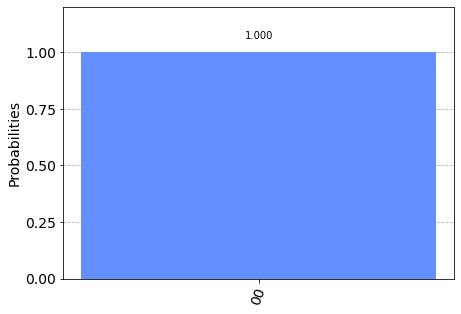

In [178]:
qc = QuantumCircuit(number, number)

for i in range(number):
    qc.rx(pred[0 * (i + 1)] * np.pi, i)
    qc.ry(pred[0 * (i + 2)] * np.pi, i)
    qc.rz(pred[0 * (i + 3)] * np.pi, i)

qc.measure(range(number), range(number))
circ = transpile(qc, backend)

qobj = assemble(circ, shots=shots)

# Run and get counts
result = backend.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [187]:
pred

array(1., dtype=float32)